## **<h3 style="color:red;">🏠 California Housing Price Prediction** 

This project aims to **predict the median house value** in California using various housing features.

<div style="background-color:#ffcccc; padding:6px; border-radius:8px;">

### <span style="color:black;">**Importing Libraries**</span>

</div>


I start by **importing the necessary libraries** for data manipulation, visualization, and machine learning:

- `pandas` & `numpy` → for data handling and numerical operations  
- `matplotlib` & `seaborn` → for plotting and visualizations  
- `sklearn.datasets` → to load the California Housing dataset  
- `sklearn.linear_model` → for regression models (`LinearRegression`, `Ridge`, `Lasso`)  
- `sklearn.model_selection` → for splitting data, cross-validation, and hyperparameter tuning  
- `sklearn.preprocessing` → for feature scaling  
- `sklearn.metrics` → for evaluating model performance (`MSE`, `R²`)  

I then **load the California Housing dataset**, which contains features such as average rooms, population, median income, and housing age, and the target variable `MedHouseVal` which represents the median house value for each area.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Load dataset
data = fetch_california_housing()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='MedHouseVal')

X.head()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


<div style="background-color:#ffcccc; padding:6px; border-radius:8px;">

### <span style="color:black;">**Exploratory Data Analysis**</span>

</div>


Before building models, I perform **exploratory data analysis** to understand the dataset:

1. Check the **shape and structure** of the dataset.
2. Inspect **data types and missing values**.
3. Analyze **feature correlations** to detect multicollinearity and relationships between variables.

In [8]:
X.shape

(20640, 8)

In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


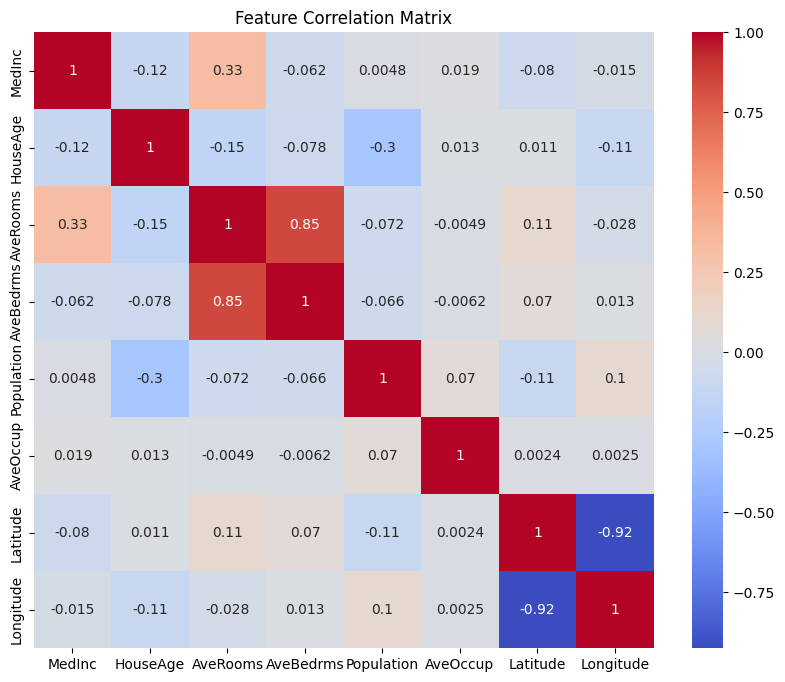

In [3]:
# Check feature correlation
plt.figure(figsize=(10, 8))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()


### ⚠️ Multicollinearity Check

Multicollinearity occurs when **features are highly correlated**, which can negatively affect regression models.  

I calculate the **Variance Inflation Factor (VIF)** for each feature:

- VIF > 5–10 indicates high multicollinearity.
- Features with high VIF may need to be removed or combined to improve model stability.


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Add constant for VIF calculation
from statsmodels.tools.tools import add_constant
X_vif = add_constant(X)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i+1) for i in range(len(X.columns))]

vif_data


,Feature,VIF
0,MedInc,2.501295
1,HouseAge,1.241254
2,AveRooms,8.342786
3,AveBedrms,6.994995
4,Population,1.138125
5,AveOccup,1.008324
6,Latitude,9.297624
7,Longitude,8.962263


### 🔎 Focused Multicollinearity Check: AveRooms vs AveBedrms

`AveRooms` and `AveBedrms` are often highly correlated.  
I calculate VIF specifically for these two features to see if multicollinearity might affect our regression models.  

- If VIF is high, I may consider **dropping or combining** one of these features in the model.


In [13]:
# Check VIF again just for these 2
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_pair = X[['AveRooms', 'AveBedrms']]
X_pair_vif = add_constant(X_pair)

vif_data = pd.DataFrame()
vif_data['Feature'] = X_pair.columns
vif_data['VIF'] = [variance_inflation_factor(X_pair_vif.values, i+1) for i in range(len(X_pair.columns))]

vif_data


,Feature,VIF
0,AveRooms,3.551917
1,AveBedrms,3.551917


### 🧩 Train-Test Split and Feature Scaling

Before training models, I need to:

1. **Split the dataset** into **training** (80%) and **testing** (20%) sets to evaluate model performance on unseen data.
2. **Standardize features** using `StandardScaler`:

   - Scaling ensures all features have **mean = 0** and **standard deviation = 1**.
   - This is important for regression models and regularization techniques (Ridge, Lasso), which are sensitive to feature magnitudes.


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


<div style="background-color:#ffcccc; padding:6px; border-radius:8px;">

### <span style="color:black;">**Model Training and Coefficient Analysis**</span>

</div>


After preprocessing, we train **Linear Regression** and **regularized regression models** to predict house prices.  

### 1️⃣ Ordinary Least Squares (OLS) Regression
- Fit a **Linear Regression** model on standardized features.
- Visualize the **coefficients** to see the impact of each feature on the median house value.
- OLS coefficients can be **unstable** when features are correlated.

### 2️⃣ Ridge Regression
- Apply **Ridge Regression** to reduce coefficient instability caused by multicollinearity.
- `RidgeCV` performs **cross-validation** to find the best regularization parameter `alpha`.
- Visualize the Ridge coefficients for comparison with OLS.

### 3️⃣ Lasso Regression (Optional)
- Apply **Lasso Regression** for **feature selection and sparsity**.
- Lasso can shrink some coefficients to zero, highlighting the most important features.
- `LassoCV` finds the optimal `alpha` using cross-validation.


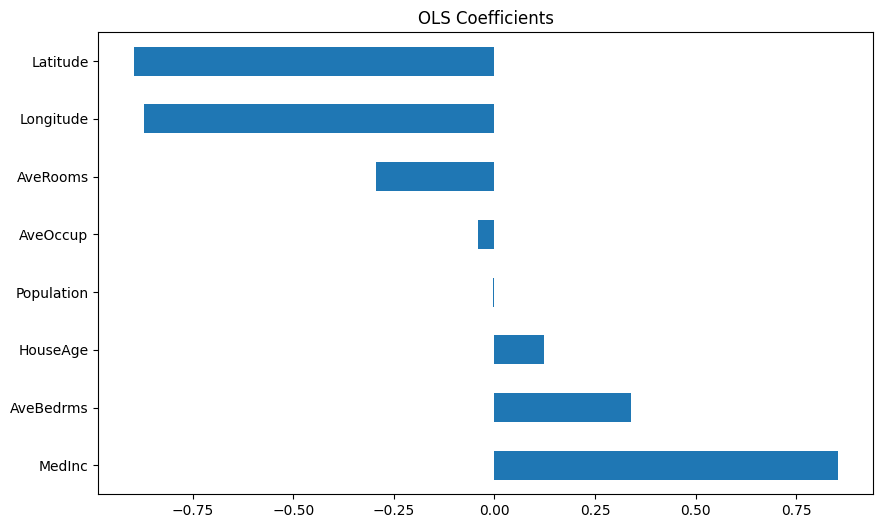

In [25]:
# 1 Visualize Coefficient Instability in OLS 
ols = LinearRegression()
ols.fit(X_train_scaled, y_train)

coeff_df = pd.Series(ols.coef_, index=X.columns)
coeff_df.sort_values(ascending=False).plot(kind='barh', figsize=(10, 6))
plt.title("OLS Coefficients")
plt.show()


Best Ridge alpha: 0.1


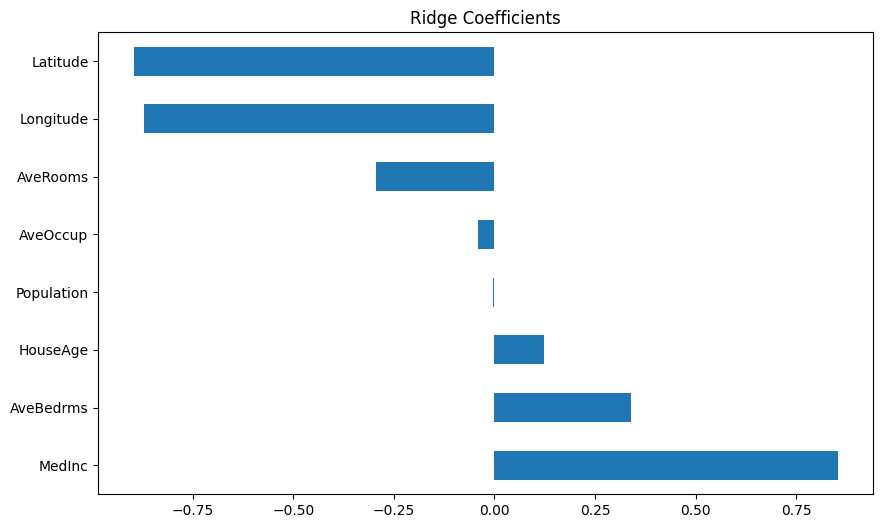

In [26]:
# 2 Train Ridge and Compare
from sklearn.linear_model import RidgeCV

alphas = [0.01, 0.1, 1, 10, 100]
ridge_cv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error', cv=5)
ridge_cv.fit(X_train_scaled, y_train)

print("Best Ridge alpha:", ridge_cv.alpha_) # cv=5 means 5folds cross-validation means 5 equal parts 
ridge_coefs = pd.Series(ridge_cv.coef_, index=X.columns)

ridge_coefs.sort_values(ascending=False).plot(kind='barh', figsize=(10, 6))
plt.title("Ridge Coefficients")
plt.show()


Best Lasso alpha: 0.01


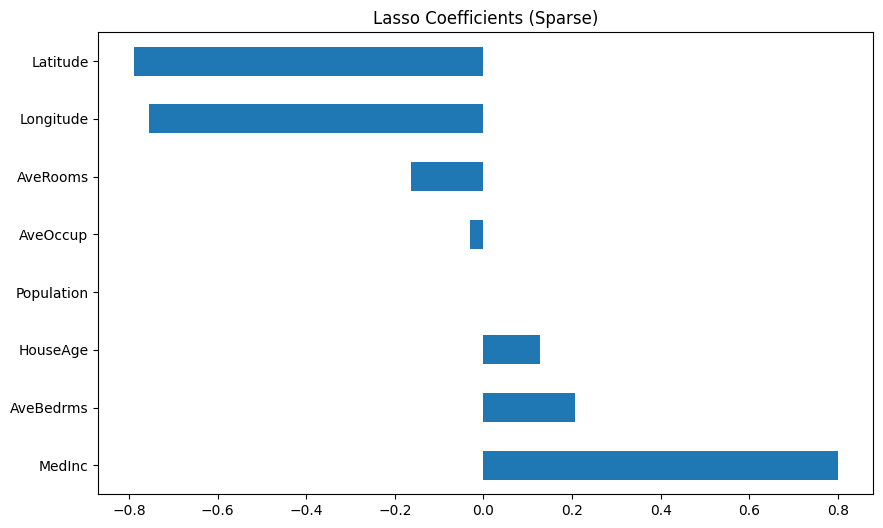

In [27]:
# 3 Optional: Train Lasso and Compare
from sklearn.linear_model import LassoCV

lasso_cv = LassoCV(alphas=alphas, max_iter=10000, cv=5)
lasso_cv.fit(X_train_scaled, y_train)

print("Best Lasso alpha:", lasso_cv.alpha_)
lasso_coefs = pd.Series(lasso_cv.coef_, index=X.columns)

lasso_coefs.sort_values(ascending=False).plot(kind='barh', figsize=(10, 6))
plt.title("Lasso Coefficients (Sparse)")
plt.show()


<div style="background-color:#ffcccc; padding:6px; border-radius:8px;">

### <span style="color:black;">**Model Evaluation**</span>

</div>

i evaluate the performance of **Linear Regression**, **Ridge**, and **Lasso** models using:

- **RMSE (Root Mean Squared Error):** measures prediction error magnitude.
- **R² Score:** measures proportion of variance explained by the model.
- **Non-zero coefficients:** to see how Lasso promotes sparsity.

Finally, I compare all three models side by side and optionally inspect which features Lasso has eliminated.


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Ridge Performance
# Predict
y_ridge_pred = ridge_cv.predict(X_test_scaled)

# Evaluation
print("Ridge Test RMSE:", np.sqrt(mean_squared_error(y_test, y_ridge_pred)))
print("Ridge Test R²:", r2_score(y_test, y_ridge_pred))


Ridge Test RMSE: 0.7455789118982764
Ridge Test R²: 0.5757905180002315


In [ ]:
# Lasso Performance
y_lasso_pred = lasso_cv.predict(X_test_scaled)

print("Lasso Test RMSE:", np.sqrt(mean_squared_error(y_test, y_lasso_pred)))
print("Lasso Test R²:", r2_score(y_test, y_lasso_pred))


Lasso Test RMSE: 0.7404423656125414
Lasso Test R²: 0.5816154300698727


In [ ]:
# Linear Regression Performance
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_lr_pred = lr.predict(X_test_scaled)

print("Linear Regression Test RMSE:", np.sqrt(mean_squared_error(y_test, y_lr_pred)))
print("Linear Regression Test R²:", r2_score(y_test, y_lr_pred))


Linear Regression Test RMSE: 0.7455813830127763
Linear Regression Test R²: 0.575787706032451


In [ ]:
# Compare all models side by side
models_comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Ridge', 'Lasso'],
    'Test RMSE': [
        np.sqrt(mean_squared_error(y_test, y_lr_pred)),
        np.sqrt(mean_squared_error(y_test, y_ridge_pred)),
        np.sqrt(mean_squared_error(y_test, y_lasso_pred))
    ],
    'Test R²': [
        r2_score(y_test, y_lr_pred),
        r2_score(y_test, y_ridge_pred),
        r2_score(y_test, y_lasso_pred)
    ],
    'Non-zero Coefficients': [
        np.sum(lr.coef_ != 0),
        np.sum(ridge_cv.coef_ != 0),
        np.sum(lasso_cv.coef_ != 0)
    ]
})

models_comparison


,Model,Test RMSE,Test R²,Non-zero Coefficients
0,Linear Regression,0.745581,0.575788,8
1,Ridge,0.745579,0.575791,8
2,Lasso,0.740442,0.581615,7


In [24]:
# Optional: Check which features were eliminated by Lasso
lasso_coefs[lasso_coefs == 0]


Population   -0.0
dtype: float64

### **Lasso Feature Selection Insight**
**Population Was Dropped by Lasso**

- 🔍 **What it means:** Lasso determined that Population does not add significant predictive value when combined with the other features, so its coefficient was set to 0.
- 🧠 **Why this is good:**
  - Simplifies the model (from 8 to 7 features)
  - Maintains or improves test set performance
  - Reveals that Population may be redundant given other variables (e.g., AveOccup or AveRooms)


### 📈 **Lasso Predictions vs Actual Values**

We visualize how well the **Lasso Regression model** predicts the median house value:

- The **scatter plot** shows predicted vs actual values.
- The **red dashed line** represents perfect predictions (y = x).
- Points close to the line indicate **accurate predictions**, while points far from the line indicate **errors**.


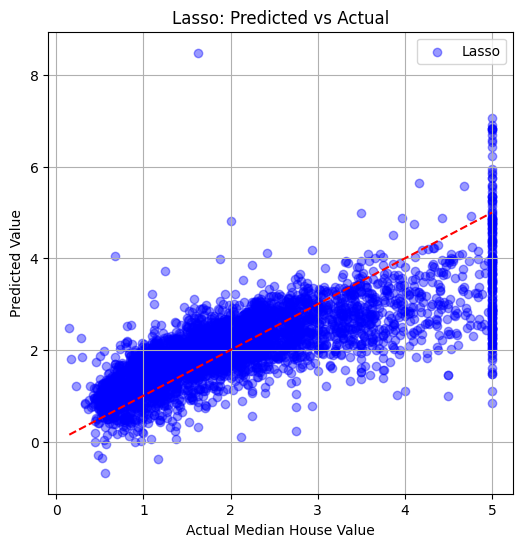

In [23]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_lasso_pred, alpha=0.4, label='Lasso', color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel('Actual Median House Value')
plt.ylabel('Predicted Value')
plt.title('Lasso: Predicted vs Actual')
plt.legend()
plt.grid(True)
plt.show()


<div style="background-color:#ffcccc; padding:6px; border-radius:8px;">

### <span style="color:black;">**Conclusion & Insights**</span>

</div>

- I analyzed the California Housing dataset and explored feature relationships.
- I checked for multicollinearity using **VIF** and found some correlated features.
- I trained three models: **Linear Regression**, **Ridge**, and **Lasso**.
- **Lasso** performed feature selection by dropping `Population` and simplified the model.
- All models were evaluated on the test set using **RMSE** and **R²**, and performance was compared.
- The **scatter plot** shows how well Lasso predicts the median house value, with most points close to the y=x line.
